<a href="https://colab.research.google.com/github/tllussa/TFM-UOC-MU-DATA-SCIENCE/blob/main/IsolationForestDadesHist%C3%B2riques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
import plotly.graph_objects as go
import math
np.random.seed(1)

## Càrrega de les dades

In [2]:
# Code to read csv file into Colaboratory:
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.BytesIO(uploaded['SentDATA.csv']))
# Dataset is now stored in a Pandas Dataframe
df = pd.read_csv('../data/SentDATA.csv')

df.reset_index(inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

## Transformació de dades

In [3]:
columns = ['PM1','PM25','PM10','PM1ATM','PM25ATM','PM10ATM']

df1 = df.copy();

df1 = df1.rename(columns={"PM 1":"PM1","PM 2.5":"PM25","PM 10":"PM10","PM 1 ATM":"PM1ATM","PM 2.5 ATM":"PM25ATM","PM 10 ATM":"PM10ATM"})

df1['PM1'] = df['PM 1'].astype(np.float32)
df1['PM25'] = df['PM 2.5'].astype(np.float32)
df1['PM10'] = df['PM 10'].astype(np.float32)
df1['PM1ATM'] = df['PM 1 ATM'].astype(np.float32)
df1['PM25ATM'] = df['PM 2.5 ATM'].astype(np.float32)
df1['PM10ATM'] = df['PM 10 ATM'].astype(np.float32)

In [4]:
#Info of dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4989 entries, 2019-09-16 10:53:47 to 2019-11-18 23:07:07
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    4989 non-null   int64  
 1   PM1      4989 non-null   float32
 2   PM25     4989 non-null   float32
 3   PM10     4989 non-null   float32
 4   PM1ATM   4989 non-null   float32
 5   PM25ATM  4989 non-null   float32
 6   PM10ATM  4989 non-null   float32
dtypes: float32(6), int64(1)
memory usage: 194.9 KB


## Crear dades d'entrenament i de test

In [5]:
df2 = df1.copy()
train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train, test = df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]
train.shape, test.shape

((3991, 7), (998, 7))

## PCA

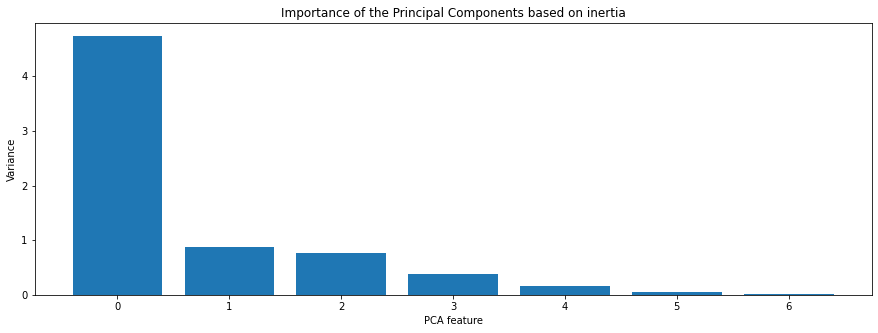

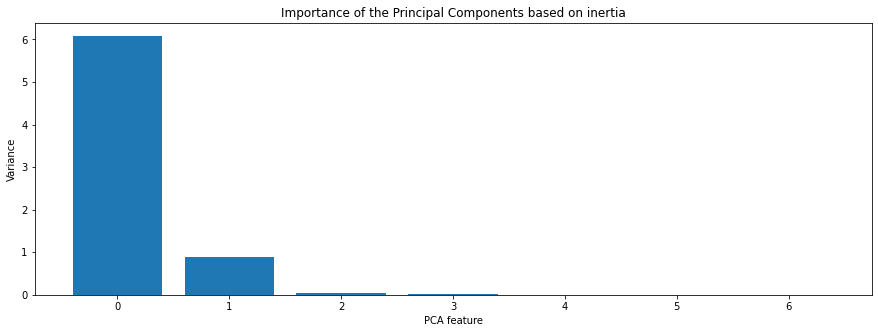

In [6]:
# Standardize/scale the dataset and apply PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns

train_names=train.columns
test_names=test.columns
x_train = train[train_names]
x_test = test[test_names]

scaler = StandardScaler()
pca = PCA()

pipeline = make_pipeline(scaler, pca)

pipeline.fit(x_train)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = pyplot.figure(figsize=(15, 5))
_ = pyplot.bar(features, pca.explained_variance_)
_ = pyplot.xlabel('PCA feature')
_ = pyplot.ylabel('Variance')
_ = pyplot.xticks(features)
_ = pyplot.title("Importance of the Principal Components based on inertia")
pyplot.show()

pipeline.fit(x_test)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = pyplot.figure(figsize=(15, 5))
_ = pyplot.bar(features, pca.explained_variance_)
_ = pyplot.xlabel('PCA feature')
_ = pyplot.ylabel('Variance')
_ = pyplot.xticks(features)
_ = pyplot.title("Importance of the Principal Components based on inertia")
pyplot.show()



In [7]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [8]:
principalDf.head()

,pc1,pc2
0,-1995.018223,-1.367774
1,-1994.030386,1.043337
2,-1993.018248,-1.357647
3,-1992.030411,1.053464
4,-1991.018274,-1.347519


In [9]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_test)
principalDf_test = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [10]:
principalDf_test.head()

,pc1,pc2
0,498.518527,-1.591516
1,497.512365,-0.597767
2,496.518563,-1.603496
3,495.518581,-1.609486
4,494.518599,-1.615476


In [11]:
from statsmodels.tsa.stattools import adfuller
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc2'])
# Print p-value
print(result[1])

c:\python38\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


4.8828286394131e-07


In [12]:
from statsmodels.tsa.stattools import adfuller
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf_test['pc2'])
# Print p-value
print(result[1])

1.8288232950435077e-05


# Creació del Model

In [13]:
# Import IsolationForest
from sklearn.ensemble import IsolationForest
 
outliers_fraction = 0.067
model =  IsolationForest(max_samples=36,contamination=outliers_fraction)
model.fit(principalDf.values) 

IsolationForest(contamination=0.067, max_samples=36)

# Predicció del Model

In [14]:
principalDf['anomalies'] = pd.Series(model.predict(principalDf.values))
principalDf_test['anomalies'] = pd.Series(model.predict(principalDf_test.values))

# Visualització

<ipython-input-15-5d139f270021>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['anomalies'] = pd.Series(principalDf['anomalies'].values, index=train.index)
<ipython-input-15-5d139f270021>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['anomalies'] = pd.Series(principalDf_test['anomalies'].values, index=test.index)


Count Outliers Train: 275
Predict Outliers Train: 264
Accuracy percentage Train: 96.0
Count Outliers Test: 0
Predict Outliers Test: 3


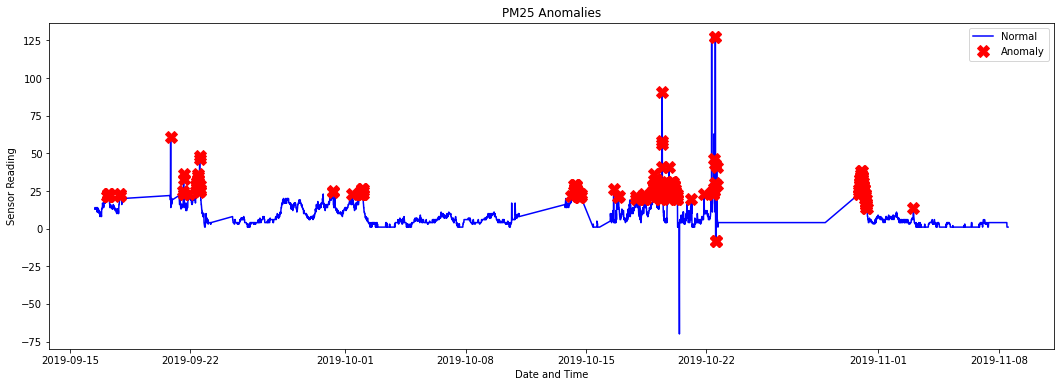

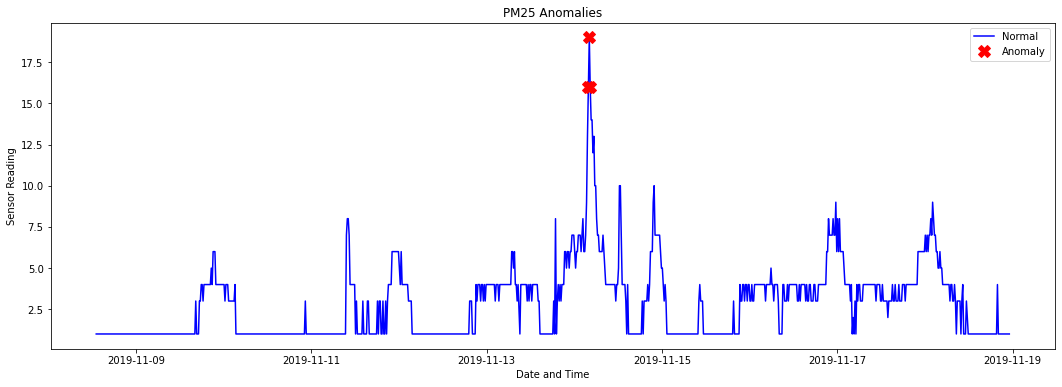

In [15]:
train['anomalies'] = pd.Series(principalDf['anomalies'].values, index=train.index)
test['anomalies'] = pd.Series(principalDf_test['anomalies'].values, index=test.index)

outliers_counter = len(train[train['PM25'] > 20])
print("Count Outliers Train:",outliers_counter)
print("Predict Outliers Train:",list(train['anomalies']).count(-1))
print("Accuracy percentage Train:", 100*list(train['anomalies']).count(-1)/(outliers_counter))

outliers_counterTest = len(test[test['PM25'] > 20])
print("Count Outliers Test:",outliers_counterTest)
print("Predict Outliers Test:",list(test['anomalies']).count(-1))


anomalies = train.loc[train['anomalies'] == -1] #anomaly
_ = pyplot.figure(figsize=(18,6))
_ = pyplot.plot(train['PM25'], color='blue', label='Normal')
_ = pyplot.plot(anomalies['PM25'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = pyplot.xlabel('Date and Time')
_ = pyplot.ylabel('Sensor Reading')
_ = pyplot.title('PM25 Anomalies')
_ = pyplot.legend(loc='best')
pyplot.show();

anomalies_test = test.loc[test['anomalies'] == -1] #anomaly
_ = pyplot.figure(figsize=(18,6))
_ = pyplot.plot(test['PM25'], color='blue', label='Normal')
_ = pyplot.plot(anomalies_test['PM25'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = pyplot.xlabel('Date and Time')
_ = pyplot.ylabel('Sensor Reading')
_ = pyplot.title('PM25 Anomalies')
_ = pyplot.legend(loc='best')
pyplot.show();